In [1]:
import numpy as np
import math
from scipy.linalg import expm
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.animation as ani 

In [2]:
def position(H):
    P = np.zeros(len(H))
    P[math.ceil(len(P)/2)-1] = 1
    G = np.zeros(len(H))
    for i in range(len(H)):
        G[i] = i
    return P, G

def unitary_evolution(H, P, t):
    x = np.dot(1j,H)
    U = expm(np.dot(t,x))
    psi = np.matmul(P,U)
    return psi

In [37]:
def CTQW(hadamard, N, tstart, tend):
    """Function that takes in an adjacency matrix and returns the unitary evolution operator, and plots the evolution visually"""
    H = hadamard(N)
    #defining the position array and central vertex
    P, G = position(H)
    #define time array
    T = np.linspace(tstart,tend,int((tend-tstart)*5))
    #defining 'z' array for probabilities
    Z = np.zeros((len(G), len(T))) 
    probs = []

    #unitary evolution for each time step
    for i in range(len(T)):
        t_i = T[i]
        prob = 0
        psi_i = unitary_evolution(H, P, t_i)
        for k in range(len(psi_i)):
            psi_i[k] = abs(psi_i[k])**2
            prob += psi_i[k]
        probs.append(round(prob,3))
        #mapping the probability to the 2D z array
        for j in range(len(G)):
            Z[j][i] = psi_i[j]
            

    c = int(len(T)/5)

    #plot contour
    plt.contourf(T,G,Z, cmap='YlOrRd')
    plt.colorbar(label='Probability')
    plt.clim(0,1.0)
    plt.title(f'Continuous Time Quantum Walk for {tend-tstart} seconds')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Position')
    plt.axvline(x=T[c], color='navy')
    plt.axvline(x=T[-1], color='lime')
    plt.show()

    Z_t = np.transpose(Z)
    #plot mid and final probability
    plt.bar(G, Z_t[c], color='navy')
    plt.title(f'Continuous Time Quantum Walk after {round(T[c], 2)} seconds')
    plt.xlabel('Position')
    plt.ylabel('Probability')
    plt.show()
    plt.bar(G, Z_t[-1], color='lime')
    plt.title(f'Continuous Time Quantum Walk after {tend} seconds')
    plt.xlabel('Position')
    plt.ylabel('Probability')
    plt.show()

    plt.plot(T, probs)
    plt.title('Total Probability')
    plt.xlabel('Time')
    plt.ylabel('Total Probability')  
    plt.show()  

    return T,G,Z, probs

In [7]:
def line_hadamard(N):
    a = np.zeros((1, N))[0]
    b = np.ones((1, N-1))[0]
    H = np.diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)

    A = nx.from_numpy_matrix(np.array(H))  
    nx.draw_spectral(A, with_labels=True)
    plt.title('Line Graph')
    plt.show()

    return H 

In [8]:
def loop_hadamard(N):
    a = np.zeros((1, N))[0]
    b = np.ones((1, N-1))[0]
    H = np.diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)
    H[0][N-1] = 1
    H[N-1][0] = 1

    A = nx.from_numpy_matrix(np.array(H))  
    nx.draw_circular(A, with_labels=True)
    plt.title('Loop Graph')
    plt.show()

    return H 

In [31]:
def loop_plus_hadamard(N):
    a = np.zeros((1, N))[0]
    b = np.ones((1, N-1))[0]
    H = np.diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)
    H[0][N-1] = 1
    H[N-1][0] = 1
    H[0][2] = 1
    H[2][0] = 1

    A = nx.from_numpy_matrix(np.array(H))  
    nx.draw_circular(A, with_labels=True)
    plt.title('Loop with extra connection Graph')
    plt.show()

    return H 

In [12]:
def peterson_hadamard(N):
    graph = nx.petersen_graph()

    nx.draw_shell(graph, with_labels=True, nlist=[range(5, 10), range(5)])
    plt.title('Petersen Graph')
    plt.show()

    A = nx.linalg.graphmatrix.adjacency_matrix(graph)
    H = np.array(A.todense())
    
    return H 

In [13]:
def mobius_hadamard(N):
    graph = nx.moebius_kantor_graph()

    nx.draw_circular(graph, with_labels=True)
    plt.title('Moebius Kantor Graph')
    plt.show()

    A = nx.linalg.graphmatrix.adjacency_matrix(graph)
    H = np.array(A.todense())
    
    return H 

In [14]:
def ladder_hadamard(N):
    graph = nx.ladder_graph(N)

    nx.draw_circular(graph, with_labels=True)
    plt.title('Ladder Graph')
    plt.show()

    A = nx.linalg.graphmatrix.adjacency_matrix(graph)
    H = np.array(A.todense())
    
    return H 

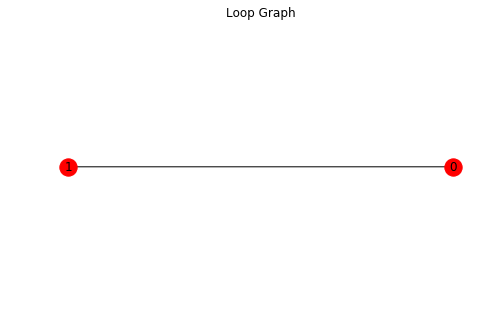

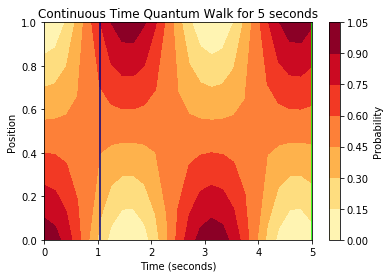

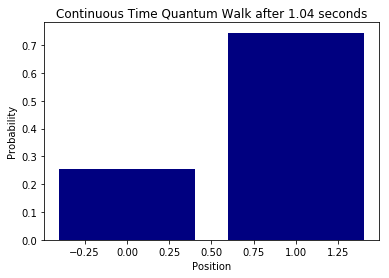

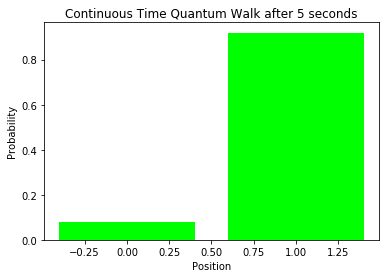

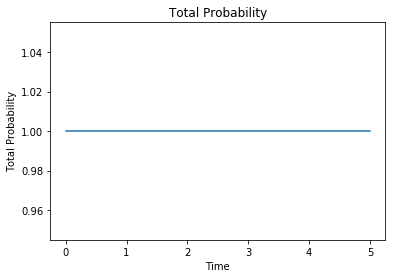

In [38]:
x,y,z,p = CTQW(loop_hadamard, 2, 0, 5)